Загружаем все необходимые библиотеки и датасеты с рекламными кампаниями.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import datetime
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'plotly_white'

control_data = pd.read_csv('/content/Control.csv', sep=';')
test_data = pd.read_csv('/content/Test.csv', sep=';')
control_data.head()

,group,ddate,views,clicks,spent,basket,orders,orders_money
0,A,02.09.2025,471,17,97,7,0,0
1,A,03.09.2025,5398,90,276,6,3,3549
2,A,04.09.2025,10912,146,876,20,15,4467
3,A,05.09.2025,10093,162,1131,22,4,1404
4,A,04.09.2025,789,27,329,8,2,3395


Рис. 1: Датасет с данными контрольной кампании

In [2]:
test_data.head()

,group,ddate,views,clicks,spent,basket,orders,orders_money
0,B,03.09.2025,6100,108,308,6,2,2350
1,B,04.09.2025,10084,132,792,24,5,1441
2,B,01.09.2025,9953,176,1221,39,8,2899
3,B,01.09.2025,997,37,418,10,5,8330
4,B,01.09.2025,30942,261,1512,52,15,6323


Рис. 2: Датасет с данными тестовой кампании

Посмотрим на размеры датасетов.

In [3]:
print('В датасете №1 строк/колонок:', control_data.shape)
print('В датасете №2 строк/колонок:', test_data.shape)

В датасете №1 строк/колонок: (50, 8)
В датасете №2 строк/колонок: (50, 8)


Проверяем данные на количество NaN значений.

In [4]:
control_data.isnull().sum()

,0
group,0
ddate,0
views,0
clicks,0
spent,0
basket,0
orders,0
orders_money,0


In [5]:
test_data.isnull().sum()

,0
group,0
ddate,0
views,0
clicks,0
spent,0
basket,0
orders,0
orders_money,0


Проверяем типы данных столбцов.

In [6]:
print(control_data.dtypes)
print(test_data.dtypes)

group           object
ddate           object
views            int64
clicks           int64
spent            int64
basket           int64
orders           int64
orders_money     int64
dtype: object
group           object
ddate           object
views            int64
clicks           int64
spent            int64
basket           int64
orders           int64
orders_money     int64
dtype: object


Видим, что оба датасета имеют одинаковое число строк и столбцов, а также одинаковый тип данных. Однако в названиях столбцов есть ошибки и лишние символы.

In [7]:
control_data.columns = ['group', 'ddate', 'views',
                        'clicks', 'spent', 'basket',
                        'orders', 'orders_money']

test_data.columns = ['group', 'ddate', 'views',
                        'clicks', 'spent', 'basket',
                        'orders', 'orders_money']

print(control_data.columns)
print(test_data.columns)

Index(['group', 'ddate', 'views', 'clicks', 'spent', 'basket', 'orders',
       'orders_money'],
      dtype='object')
Index(['group', 'ddate', 'views', 'clicks', 'spent', 'basket', 'orders',
       'orders_money'],
      dtype='object')


Объединим эти две таблицы. Создадим новый датасет ab_data.

In [8]:
ab_data = control_data.merge(test_data, how='outer').sort_values(['ddate'])
ab_data = ab_data.reset_index(drop=True)
ab_data.head()

,group,ddate,views,clicks,spent,basket,orders,orders_money
0,A,01.09.2025,0,0,0,0,1,245
1,B,01.09.2025,30942,261,1512,52,15,6323
2,B,01.09.2025,9953,176,1221,39,8,2899
3,B,01.09.2025,6669,626,7313,332,214,64008
4,B,01.09.2025,5466,425,7477,312,163,24916


Рис. 3: Объединенный датасет с контрольными и тестовыми значениями ab_data

Видим что объединение таблиц прошло успешно. Однако на всякий случай посчитаем количество значений в столбце group.

In [9]:
ab_data['group'].value_counts()

,count
group,
A,50
B,50


Число строк для контрольной и тестовой кампании совпадают. Приступаем к A/B-тестам наших данных.

**Визуальный анализ результатов A/B-теста**

Проводим визуальный анализ различий ключевых метрик рекламных кампаний. Рассмотрим соотношения между количеством показов, которые мы получили от обеих кампаний, и суммой, потраченной на обе кампании.

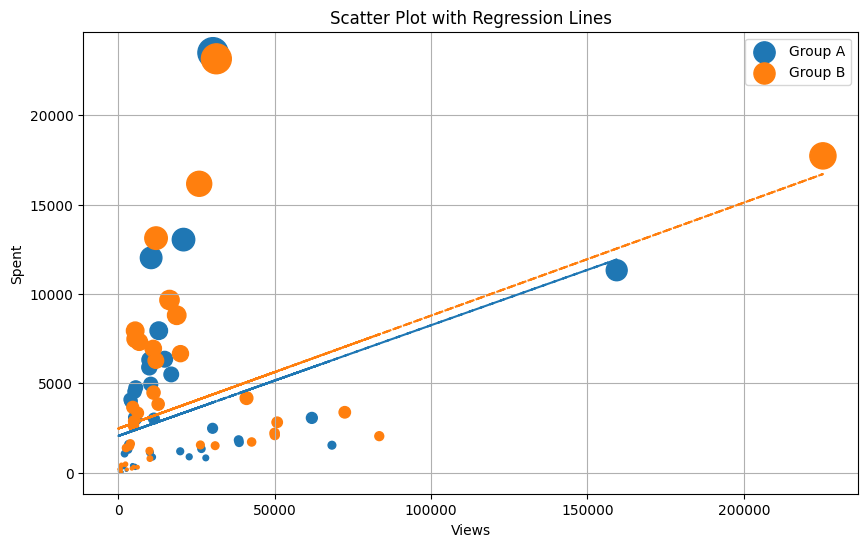

In [21]:
# Создаем график рассеяния с линиями регрессии
plt.figure(figsize=(10, 6))
for group in ab_data['group'].unique():
    subset = ab_data[ab_data['group'] == group]
    plt.scatter(subset['views'], subset['spent'], s=subset['spent'] * 0.02, label=f'Group {group}')  # Уменьшаем размер точек

    # Добавляем линию линейной регрессии
    z = np.polyfit(subset['views'], subset['spent'], 1)
    p = np.poly1d(z)
    plt.plot(subset['views'], p(subset['views']), '--')

plt.xlabel('Views')
plt.ylabel('Spent')
plt.title('Scatter Plot with Regression Lines')
plt.legend()
plt.grid(True)
plt.show()

Рис. 4: Диаграмма рассеяния с линиями тренда сумм затрат на рекламу и числа показов

На диаграмме выше синие кружки — это контрольная кампания. Красные кружки — это тестовая кампания.

Основные тезисы по диаграмме:


*   Линия тренда для каждой кампании подтверждает заввисимость, чем больше денег
потрачено на рекламу, тем больше просмотров она получает.
*   Кампания B (красные точки) в целом показывает более высокую эффективность. При меньших расходах она получает больше просмотров по сравнению с кампанией A.
*   На графике видны некоторые точки, которые сильно отклоняются от общей тенденции. Например, у кампании A есть точка с очень высокими расходами (около 25k), но относительно небольшим количеством просмотров (около 50k). Это может указывать на неэффективное использование бюджета в этом конкретном случае. У кампании B также есть точка с высокими расходами (около 20k), но просмотры составляют около 150k, что является хорошим результатом.

Теперь давайте посмотрим на количество показов в рамках обеих кампаний.

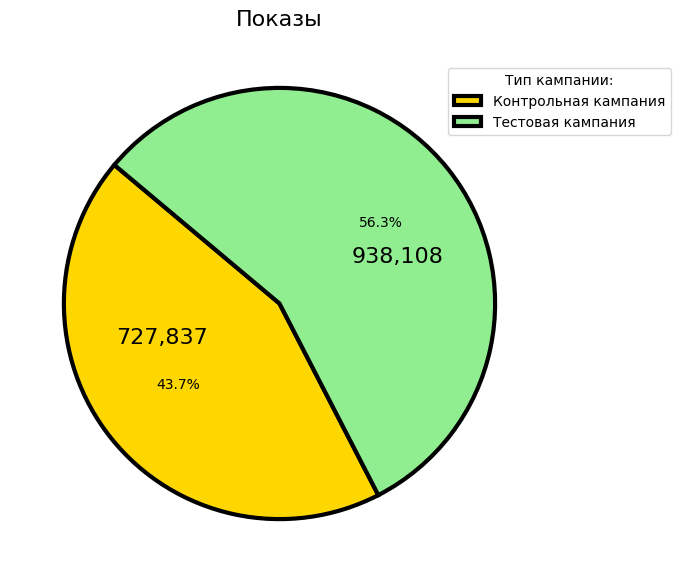

In [76]:
# Данные для круговой диаграммы
control_views = sum(control_data['views'])
test_views = sum(test_data['views'])
labels = ['Контрольная кампания', 'Тестовая кампания']
sizes = [control_views, test_views]
colors = ['gold', 'lightgreen']
explode = (0, 0)

# Создание фигуры и оси для графика
fig, ax = plt.subplots(figsize=(7, 7))

# Постройте круговую диаграмму
wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    labels=None,  # временно отключаем метки
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops=dict(color='black'),
    wedgeprops={'linewidth': 3, 'edgecolor': 'black'},
)

# Получение угла середины каждого сектора
angles = [(p.theta2 - p.theta1) / 2.0 + p.theta1 for p in wedges]

# Нормализация координат для размещения аннотаций внутри сектора
positions = []
for ang in angles:
    x = 0.7 * np.cos(np.deg2rad(ang))  # 0.7 - относительное смещение от центра
    y = 0.3 * np.sin(np.deg2rad(ang))
    positions.append((x, y))

# Аннотируем секторы числами просмотров
for i, pos in enumerate(positions):
    ax.text(*pos, f"{sizes[i]:,.0f}", fontsize=16, ha='center')

# Установка равных осей для правильного отображения круга
ax.set_aspect('equal')

# Добавление заголовка и легенды
plt.title("Показы", fontsize=16)
plt.legend(wedges, labels, title="Тип кампании:", bbox_to_anchor=(0.8, 0.95), loc="upper left")

# Отображение графика
plt.show()

Рис. 5: Круговая диаграмма сравнения числа показов в контрольной и тестовой рекламной кампании

По графику выше мы видим, что тестовая кампания генерировала больше показов (938 108 против 727 8837)

Теперь давайте посмотрим на количество кликов по карточкам в обеих кампаниях.

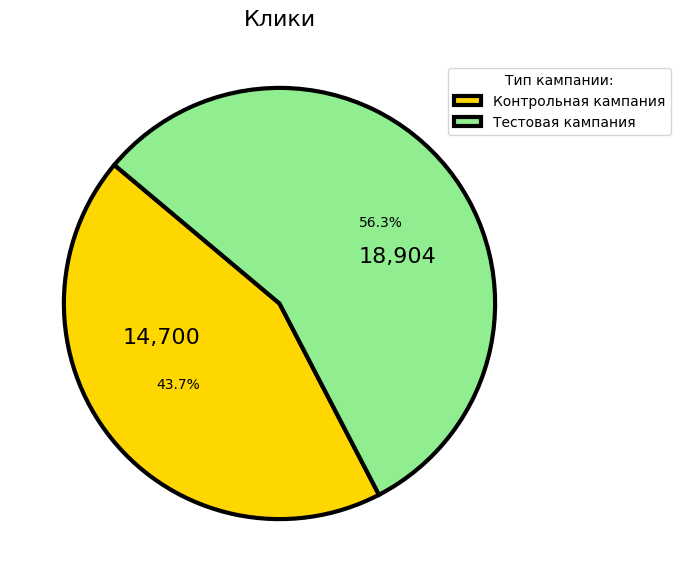

In [78]:
# Данные для круговой диаграммы
control_views = sum(control_data['clicks'])
test_views = sum(test_data['clicks'])
labels = ['Контрольная кампания', 'Тестовая кампания']
sizes = [control_views, test_views]
colors = ['gold', 'lightgreen']
explode = (0, 0)

# Создание фигуры и оси для графика
fig, ax = plt.subplots(figsize=(7, 7))

# Постройте круговую диаграмму
wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    labels=None,  # временно отключаем метки
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops=dict(color='black'),
    wedgeprops={'linewidth': 3, 'edgecolor': 'black'},
)

# Получение угла середины каждого сектора
angles = [(p.theta2 - p.theta1) / 2.0 + p.theta1 for p in wedges]

# Нормализация координат для размещения аннотаций внутри сектора
positions = []
for ang in angles:
    x = 0.7 * np.cos(np.deg2rad(ang))  # 0.7 - относительное смещение от центра
    y = 0.3 * np.sin(np.deg2rad(ang))
    positions.append((x, y))

# Аннотируем секторы числами просмотров
for i, pos in enumerate(positions):
    ax.text(*pos, f"{sizes[i]:,.0f}", fontsize=16, ha='center')

# Установка равных осей для правильного отображения круга
ax.set_aspect('equal')

# Добавление заголовка и легенды
plt.title("Клики", fontsize=16)
plt.legend(wedges, labels, title="Тип кампании:", bbox_to_anchor=(0.8, 0.95), loc="upper left")

# Отображение графика
plt.show()

Рис. 6: Круговая диаграмма сравнения числа кликов по карточке в контрольной и тестовой рекламной кампании

И здесь тестовая кампания явно сработала лучше (18 904 против 14 700).

Теперь давайте посмотрим на количество товаров, добавленных в корзину в обеих кампаниях.

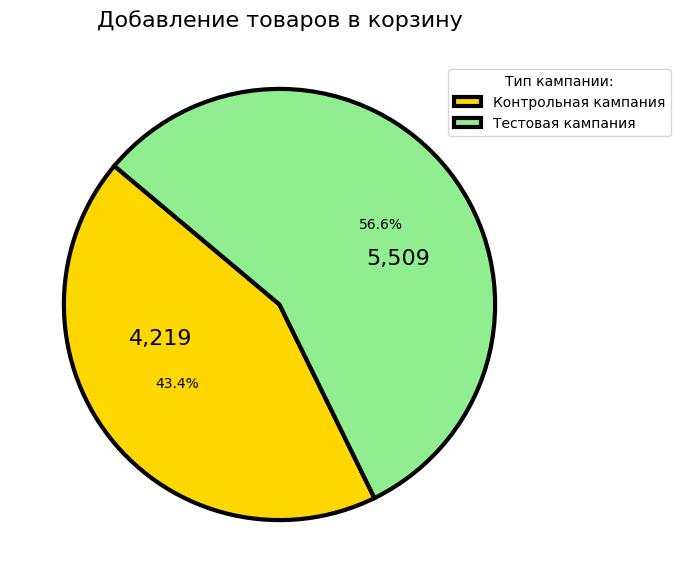

In [79]:
# Данные для круговой диаграммы
control_views = sum(control_data['basket'])
test_views = sum(test_data['basket'])
labels = ['Контрольная кампания', 'Тестовая кампания']
sizes = [control_views, test_views]
colors = ['gold', 'lightgreen']
explode = (0, 0)

# Создание фигуры и оси для графика
fig, ax = plt.subplots(figsize=(7, 7))

# Постройте круговую диаграмму
wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    labels=None,  # временно отключаем метки
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops=dict(color='black'),
    wedgeprops={'linewidth': 3, 'edgecolor': 'black'},
)

# Получение угла середины каждого сектора
angles = [(p.theta2 - p.theta1) / 2.0 + p.theta1 for p in wedges]

# Нормализация координат для размещения аннотаций внутри сектора
positions = []
for ang in angles:
    x = 0.7 * np.cos(np.deg2rad(ang))  # 0.7 - относительное смещение от центра
    y = 0.3 * np.sin(np.deg2rad(ang))
    positions.append((x, y))

# Аннотируем секторы числами просмотров
for i, pos in enumerate(positions):
    ax.text(*pos, f"{sizes[i]:,.0f}", fontsize=16, ha='center')

# Установка равных осей для правильного отображения круга
ax.set_aspect('equal')

# Добавление заголовка и легенды
plt.title("Добавление товаров в корзину", fontsize=16)
plt.legend(wedges, labels, title="Тип кампании:", bbox_to_anchor=(0.8, 0.95), loc="upper left")

# Отображение графика
plt.show()

Рис. 7: Круговая диаграмма сравнения количества событий добавления товаров в Корзину по контрольной и тестовой кампании

А вот по данной метрике уже разница между кампаниями куда более существенная (5 509 против 4 219).

Теперь давайте посмотрим на суммы, потраченные на обе кампании.

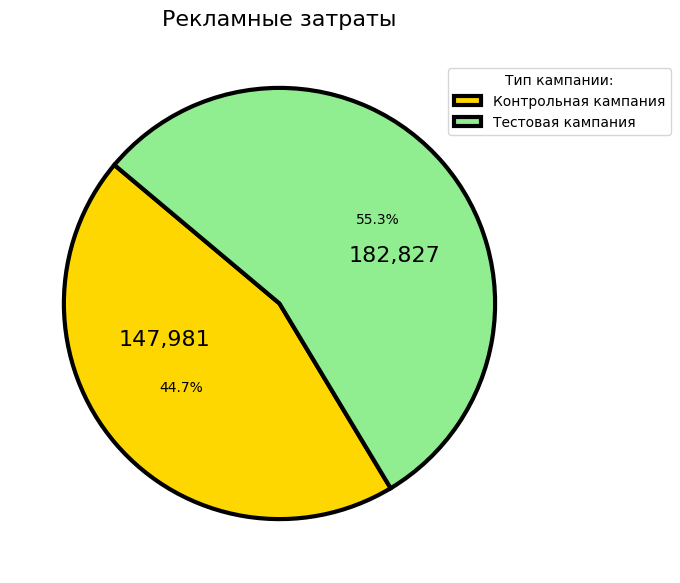

In [80]:
# Данные для круговой диаграммы
control_views = sum(control_data['spent'])
test_views = sum(test_data['spent'])
labels = ['Контрольная кампания', 'Тестовая кампания']
sizes = [control_views, test_views]
colors = ['gold', 'lightgreen']
explode = (0, 0)

# Создание фигуры и оси для графика
fig, ax = plt.subplots(figsize=(7, 7))

# Постройте круговую диаграмму
wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    labels=None,  # временно отключаем метки
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops=dict(color='black'),
    wedgeprops={'linewidth': 3, 'edgecolor': 'black'},
)

# Получение угла середины каждого сектора
angles = [(p.theta2 - p.theta1) / 2.0 + p.theta1 for p in wedges]

# Нормализация координат для размещения аннотаций внутри сектора
positions = []
for ang in angles:
    x = 0.7 * np.cos(np.deg2rad(ang))  # 0.7 - относительное смещение от центра
    y = 0.3 * np.sin(np.deg2rad(ang))
    positions.append((x, y))

# Аннотируем секторы числами просмотров
for i, pos in enumerate(positions):
    ax.text(*pos, f"{sizes[i]:,.0f}", fontsize=16, ha='center')

# Установка равных осей для правильного отображения круга
ax.set_aspect('equal')

# Добавление заголовка и легенды
plt.title("Рекламные затраты", fontsize=16)
plt.legend(wedges, labels, title="Тип кампании:", bbox_to_anchor=(0.8, 0.95), loc="upper left")

# Отображение графика
plt.show()

Рис. 8: Круговая диаграмма сравнения рекламных затрат на контрольную и тестовую кампании

Видим что на тестовую кампанию было потрачено больше средств, чем на контрольную (182 827 против 147 981). Однако поскольку в результате контрольной кампании было больше просмотров контента и больше товаров положено в корзину, мы можем сделать вывод что контрольная кампания более эффективна, чем тестовая.

Давайте также взглянем какая рекламная кампания привела к большему числу покупок с сайта.

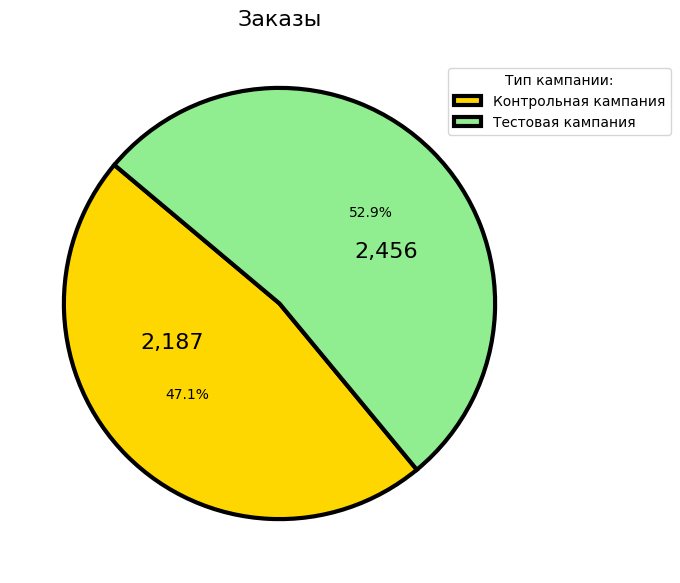

In [81]:
# Данные для круговой диаграммы
control_views = sum(control_data['orders'])
test_views = sum(test_data['orders'])
labels = ['Контрольная кампания', 'Тестовая кампания']
sizes = [control_views, test_views]
colors = ['gold', 'lightgreen']
explode = (0, 0)

# Создание фигуры и оси для графика
fig, ax = plt.subplots(figsize=(7, 7))

# Постройте круговую диаграмму
wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    labels=None,  # временно отключаем метки
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops=dict(color='black'),
    wedgeprops={'linewidth': 3, 'edgecolor': 'black'},
)

# Получение угла середины каждого сектора
angles = [(p.theta2 - p.theta1) / 2.0 + p.theta1 for p in wedges]

# Нормализация координат для размещения аннотаций внутри сектора
positions = []
for ang in angles:
    x = 0.7 * np.cos(np.deg2rad(ang))  # 0.7 - относительное смещение от центра
    y = 0.3 * np.sin(np.deg2rad(ang))
    positions.append((x, y))

# Аннотируем секторы числами просмотров
for i, pos in enumerate(positions):
    ax.text(*pos, f"{sizes[i]:,.0f}", fontsize=16, ha='center')

# Установка равных осей для правильного отображения круга
ax.set_aspect('equal')

# Добавление заголовка и легенды
plt.title("Заказы", fontsize=16)
plt.legend(wedges, labels, title="Тип кампании:", bbox_to_anchor=(0.8, 0.95), loc="upper left")

# Отображение графика
plt.show()

Рис. 9: Круговая диаграмма сравнения числа заказов с контрольной и тестовой кампании

Увеличение количества заказов на 269 (2456 - 2187) может свидетельствовать о том, что изменения, внесенные в тестовую кампанию, были эффективными.

Теперь давайте проанализируем некоторые показатели, чтобы выяснить, какая рекламная кампания приносит больше конверсий. Для этого давайте рассмотрим взаимосвязь между числом кликов по карточке и просмотренным контентом в обеих рекламных кампаниях.

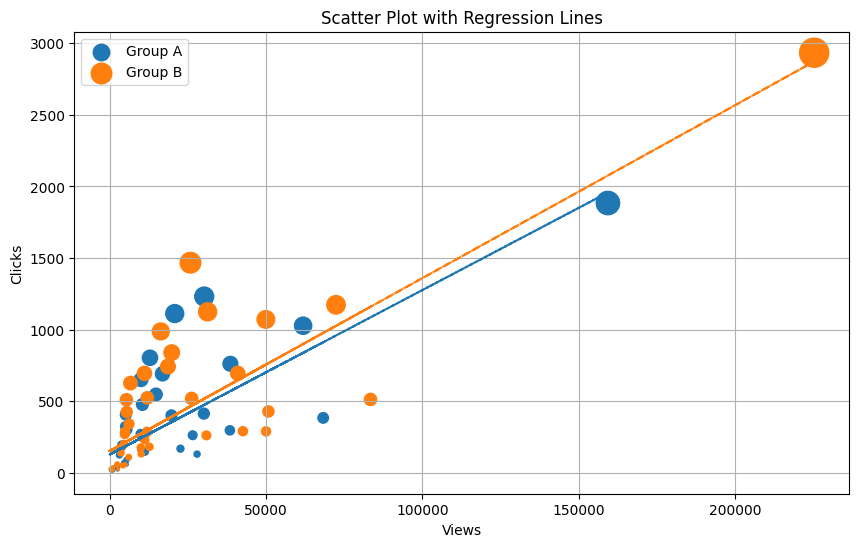

In [25]:
# Создаем график рассеяния с линиями регрессии
plt.figure(figsize=(10, 6))
for group in ab_data['group'].unique():
    subset = ab_data[ab_data['group'] == group]
    plt.scatter(subset['views'], subset['clicks'], s=subset['clicks'] * 0.15, label=f'Group {group}')  # Уменьшаем размер точек

    # Добавляем линию линейной регрессии
    z = np.polyfit(subset['views'], subset['clicks'], 1)
    p = np.poly1d(z)
    plt.plot(subset['views'], p(subset['views']), '--')

plt.xlabel('Views')
plt.ylabel('Сlicks')
plt.title('Scatter Plot with Regression Lines')
plt.legend()
plt.grid(True)
plt.show()

Рис. 10: Диаграмма рассеяния с линиями тренда кликов на карточку и количества просмотров для сравнения эффективности между тестовой и контрольной рекламными кампаниями

Группа B (красные точки и линия) имеет более высокую тенденцию к увеличению кликов по сравнению с группой A (синие точки и линия). Это может указывать на то, что контент и стратегия продвижения группы B более эффективна в привлечении кликов.

Давайте также проанализурем взаимосвязь между количеством просмотренного контента и количеством товаров, добавленных в корзину в обеих кампаниях.

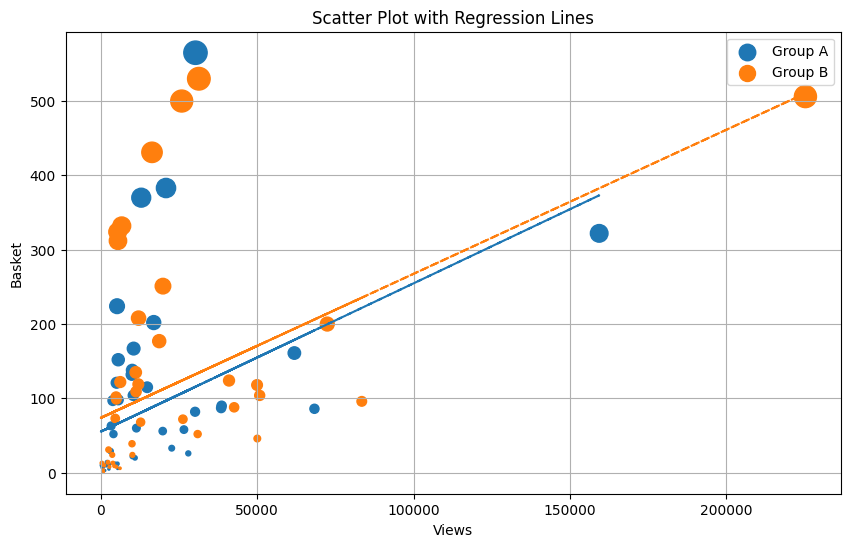

In [28]:
# Создаем график рассеяния с линиями регрессии
plt.figure(figsize=(10, 6))
for group in ab_data['group'].unique():
    subset = ab_data[ab_data['group'] == group]
    plt.scatter(subset['views'], subset['basket'], s=subset['basket'] * 0.5, label=f'Group {group}')  # Уменьшаем размер точек

    # Добавляем линию линейной регрессии
    z = np.polyfit(subset['views'], subset['basket'], 1)
    p = np.poly1d(z)
    plt.plot(subset['views'], p(subset['views']), '--')

plt.xlabel('Views')
plt.ylabel('Basket')
plt.title('Scatter Plot with Regression Lines')
plt.legend()
plt.grid(True)
plt.show()

Рис. 11: Диаграмма рассеяния с линиями тренда количества событий добавления в Корзину и числа просмотров карточек

Группа B (красные точки и линия) имеет более высокую тенденцию к увеличению просмотров по сравнению с группой A (синие точки и линия).

Выводы:

*   В результате проведенных A/B-тестов мы обнаружили, что тестовая кампания привела к увеличению заказов и вовлеченности посетителей;
*   конверсия в покупку в тестовой кампании несколько выше;
*   таким образом, тестовая кампания может быть использована для более эффективного продвижения товаров.

**Статистический анализ результатов A/B-теста**

После визуального анализа различий между контрольной и тестовой группами важно провести строгий статистический анализ, чтобы определить, являются ли наблюдаемые различия статистически значимыми.

In [18]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from datetime import datetime, timedelta


T-тест для метрики CTR:
t-статистика: -0.3968
p-значение: 0.6924
Статистически значимое различие: False
Размер эффекта (Cohen's d): 0.0802

T-тест для метрики CR_cart:
t-статистика: -0.3091
p-значение: 0.7579
Статистически значимое различие: False
Размер эффекта (Cohen's d): 0.0625

T-тест для метрики CR_purchase:
t-статистика: 0.4330
p-значение: 0.6659
Статистически значимое различие: False
Размер эффекта (Cohen's d): -0.0875

T-тест для метрики CPC:
t-статистика: -0.0079
p-значение: 0.9937
Статистически значимое различие: False
Размер эффекта (Cohen's d): 0.0016

T-тест для метрики ROI:
t-статистика: 1.1827
p-значение: 0.2398
Статистически значимое различие: False
Размер эффекта (Cohen's d): -0.2389


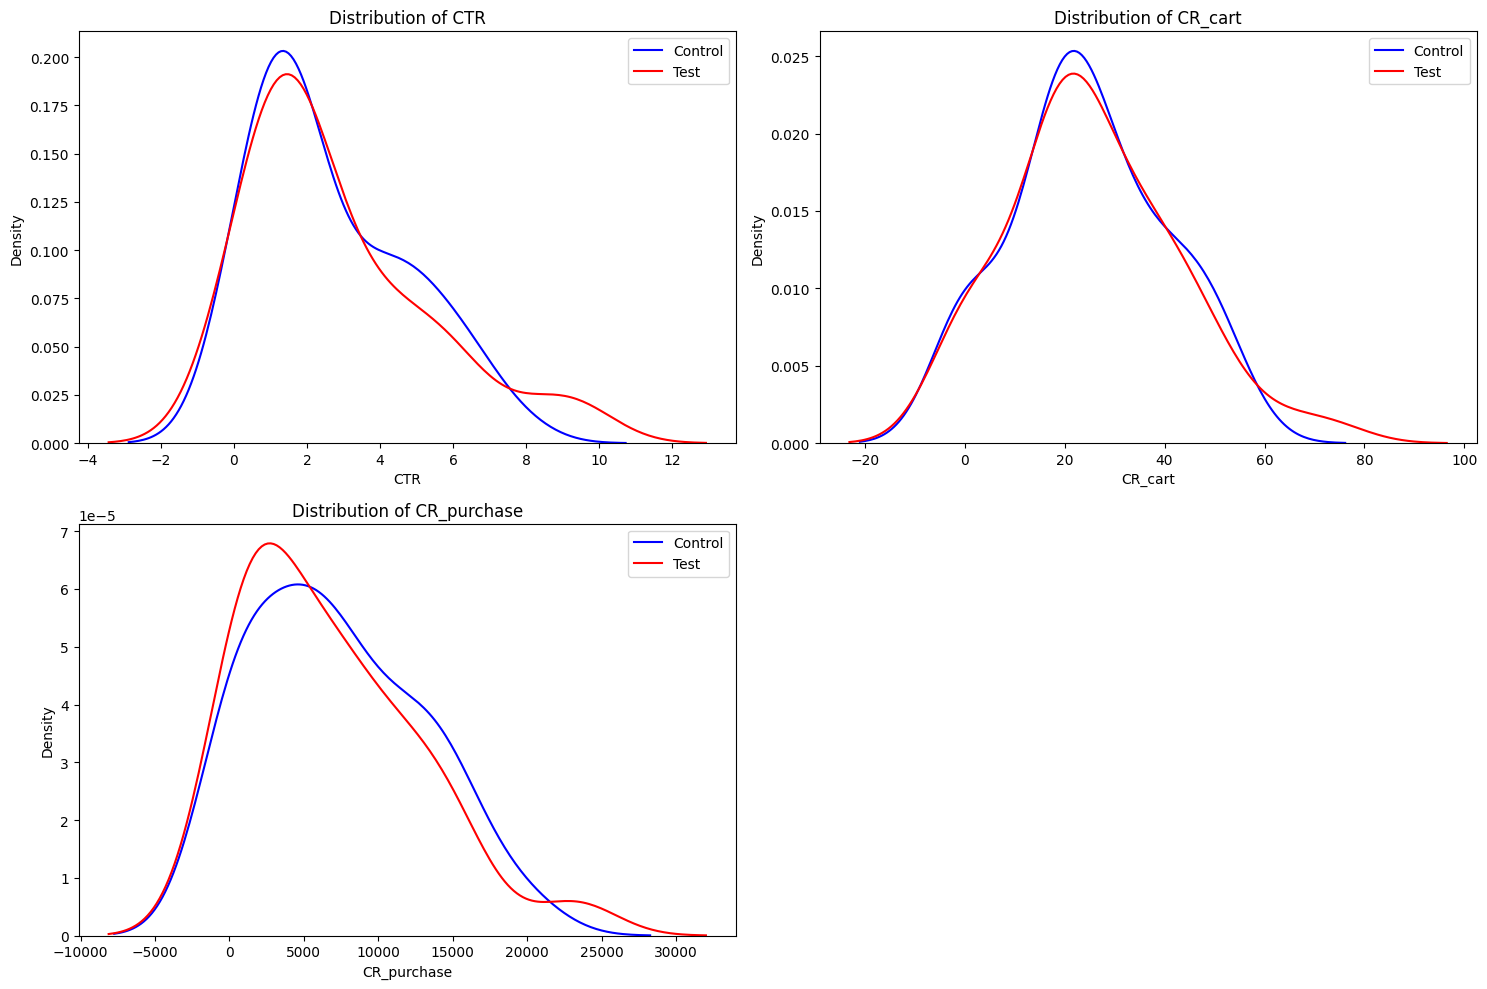

In [19]:
# Функция для расчета конверсии
def calculate_conversion_metrics(data):
    # Проверяем наличие столбца 'views' и обрабатываем деление на ноль
    metrics = pd.DataFrame()
    metrics['CTR'] = np.where(data['views'] > 0, data['clicks'] / data['views'] * 100, 0)

    # Аналогично проверяем остальные метрики
    metrics['CR_cart'] = np.where(data['clicks'] > 0, data['basket'] / data['clicks'] * 100, 0)
    metrics['CR_purchase'] = np.where(data['clicks'] > 0, data['orders_money'] / data['clicks'] * 100, 0)
    metrics['CPC'] = np.where(data['clicks'] > 0, data['spent'] / data['clicks'], 0)

    # Для ROI используем аналогичную проверку
    metrics['ROI'] = np.where(data['spent'] > 0, ((data['orders_money'] * 100 - data['spent']) / data['spent'] * 100), 0)

    return metrics

# Рассчитываем метрики для обеих групп
control_metrics = calculate_conversion_metrics(control_data)
test_metrics = calculate_conversion_metrics(test_data)

# Функция для проведения t-теста
def perform_ttest(metric_control, metric_test, metric_name):
    t_stat, p_value = stats.ttest_ind(metric_control, metric_test)
    print(f"\nT-тест для метрики {metric_name}:")
    print(f"t-статистика: {t_stat:.4f}")
    print(f"p-значение: {p_value:.4f}")
    print(f"Статистически значимое различие: {p_value < 0.05}")

# Расчет размера эффекта (Cohen's d)
    cohens_d = (np.mean(metric_test) - np.mean(metric_control)) / \
               np.sqrt((np.std(metric_test)**2 + np.std(metric_control)**2) / 2)
    print(f"Размер эффекта (Cohen's d): {cohens_d:.4f}")

# Проведем t-тесты для основных метрик
metrics_to_test = ['CTR', 'CR_cart', 'CR_purchase', 'CPC', 'ROI']
for metric in metrics_to_test:
    perform_ttest(control_metrics[metric], test_metrics[metric], metric)

# Визуализация распределения конверсий
plt.figure(figsize=(15, 10))
for i, metric in enumerate(['CTR', 'CR_cart', 'CR_purchase'], 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(data=control_metrics[metric], label='Control', color='blue')
    sns.kdeplot(data=test_metrics[metric], label='Test', color='red')
    plt.title(f'Distribution of {metric}')
    plt.legend()
plt.tight_layout()


Рис. 12: Графики распределения контрольной и тестовых выборок по значениям CTR, Добавления в Корзину, Заказов (синяя линия — контрольная кампания, красная линия — тестовая)

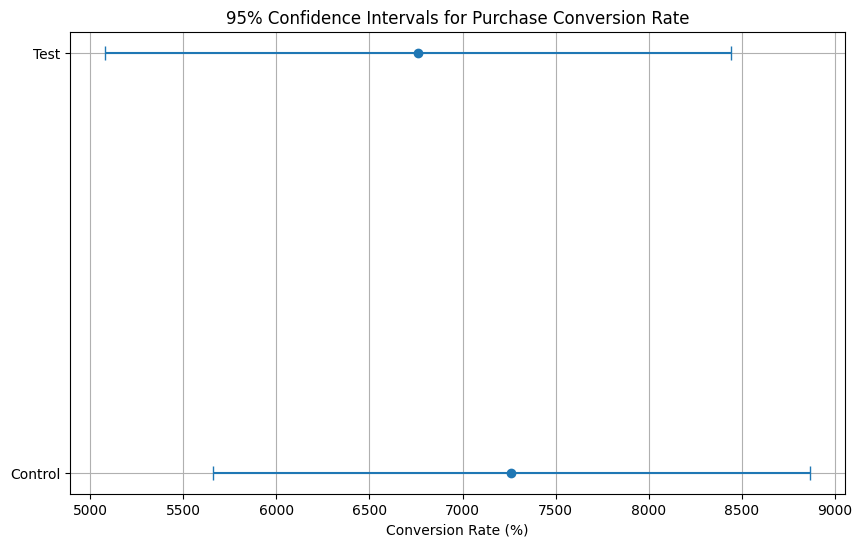

In [20]:
# Расчет доверительных интервалов
def calculate_confidence_intervals(metric_control, metric_test, metric_name):
    control_mean = np.mean(metric_control)
    test_mean = np.mean(metric_test)
    control_ci = stats.t.interval(0.95, len(metric_control)-1,
                                loc=control_mean,
                                scale=stats.sem(metric_control))
    test_ci = stats.t.interval(0.95, len(metric_test)-1,
                              loc=test_mean,
                              scale=stats.sem(metric_test))
    return pd.DataFrame({
        'Group': ['Control', 'Test'],
        'Mean': [control_mean, test_mean],
        'CI_lower': [control_ci[0], test_ci[0]],
        'CI_upper': [control_ci[1], test_ci[1]]
    })

# Расчет и визуализация доверительных интервалов для конверсии в покупку
ci_data = calculate_confidence_intervals(control_metrics['CR_purchase'],
                                      test_metrics['CR_purchase'],
                                      'Purchase Conversion Rate')

plt.figure(figsize=(10, 6))
plt.errorbar(ci_data['Mean'], ci_data['Group'],
            xerr=[(ci_data['Mean'] - ci_data['CI_lower']),
                  (ci_data['CI_upper'] - ci_data['Mean'])],
            fmt='o', capsize=5)
plt.title('95% Confidence Intervals for Purchase Conversion Rate')
plt.xlabel('Conversion Rate (%)')
plt.grid(True)

Рис. 13: 95% доверительные интервалы по конверсии в заказы товаров по контрольной и тестовой кампании

t-тест используется для проверки статистической значимости различия средних значений двух выборок.

**Метрика CTR (Click-through Rate)**

t-статистика: −0.3968

p-значение: 0.6924 > 0.05 → Нет статистически значимого различия.

Размер эффекта: 0.0802 → Очень слабый размер эффекта.

Интерпретация: Различия в среднем показателе кликов между группами практически отсутствуют и являются незначительными.


**Метрика CR_cart (Conversion Rate to Cart)**

t-статистика: −0.3091

p-значение: 0.7579 > 0.05 → Нет статистически значимого различия.

Размер эффекта: 0.0625 → Очень слабый размер эффекта.

Интерпретация: Между группами нет существенного различия в показателях конверсии добавления товаров в корзину.


**Метрика CR_purchase (Conversion Rate to Purchase)**

t-статистика: 0.4330

p-значение: 0.6659 > 0.05 → Нет статистически значимого различия.

Размер эффекта: −0.0875 → Очень слабый отрицательный размер эффекта.

Интерпретация: Показатели конверсии покупок также близки друг другу, никаких существенных отличий между группами не обнаружено.


**Метрика CPC (Cost Per Click)**

t-статистика: −0.0079

p-значение: 0.9937 > 0.05 → Нет статистически значимого различия.

Размер эффекта: 0.0016 → Чрезвычайно малый положительный размер эффекта.

Интерпретация: Стоимость каждого клика примерно одинакова в обеих группах, значимых различий нет.


**Метрика ROI (Return on Investment)**

t-статистика: 1.1827

p-значение: 0.2398 > 0.05 → Нет статистически значимого различия.

Размер эффекта: −0.2389 → Средний отрицательный размер эффекта.

Интерпретация: Хотя наблюдается небольшой отрицательный тренд в рентабельности инвестиций, этот эффект не является статистически значимым, следовательно, можно считать показатели равнозначными.

На рисунке 13 представлены 95% доверительные интервалы для коэффициентов конверсии в покупку (Purchase Conversion Rate) для двух групп: тестовой (Test) и контрольной (Control). Доверительные интервалы не пересекаются, что на первый взгляд может указывать на статистически значимое различие между группами. Однако результаты T-теста показывают, что различие не является статистически значимым.


Несмотря на то, что доверительные интервалы на графике не пересекаются, результаты T-теста показывают, что различие между группами не является статистически значимым.
Размер эффекта очень мал, что указывает на незначительное различие между группами.

**Общий вывод**

Ни одна из рассматриваемых метрик не показала статистически значимую разницу между группами. Это означает, что любые изменения, произведённые в рамках эксперимента, не оказали заметного влияния на исследуемые показатели. Размер эффектов крайне мал или даже отсутствует, что подтверждает отсутствие практических последствий изменений.
